## Imports

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import matplotlib
import pandas as pd
import numpy as np
import pyarrow.feather as feather

%load_ext rpy2.ipython

<br>

## Downloading the data

In [2]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshareclimate_data/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

In [4]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 6.49 s, sys: 6.26 s, total: 12.7 s
Wall time: 2min 17s


<br>

## Extract contents of zipped file

In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(f'{output_directory}/data')

CPU times: user 14.7 s, sys: 963 ms, total: 15.6 s
Wall time: 16.2 s


<br>

## Remove unused file

In [6]:
unused_file = os.path.join(
    output_directory,
    "data/observed_daily_rainfall_SYD.csv")
if os.path.exists(unused_file):
    os.remove(unused_file)

<br>

## Combining data CSVs

In [7]:
%%time
files = glob.glob('figshareclimate_data/data/*.csv')
df = pd.concat(
    (pd.read_csv(file, index_col=0, parse_dates=['time'])
     .assign(model=re.findall(r'[^\/]+(?=_daily_rainfall_NSW\.)', file)[0])
     for file in files)
)
df.to_csv("figshareclimate_data/combined_data.csv")

CPU times: user 6min 56s, sys: 10.4 s, total: 7min 6s
Wall time: 7min 11s


<br>

## EDA in Python

**Question:** What is the mean aggregated rainfall predicted by all the models for 2014?

#### 1. Naive method

CPU times: user 52.2 s, sys: 10.4 s, total: 1min 2s
Wall time: 1min 12s


<AxesSubplot:xlabel='Time', ylabel='Rainfall (mm/day)'>

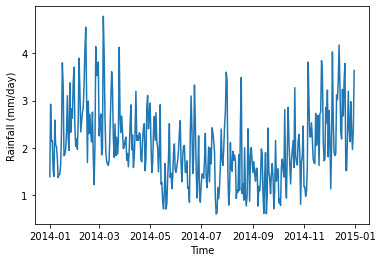

In [8]:
%%time
df = pd.read_csv(
    "figshareclimate_data/combined_data.csv",
    parse_dates=["time"]
).query("time >= '2014-01-01' and time <= '2014-12-31'")
df["time"] = df["time"].dt.date

agg_df = df.groupby(by="time").mean()
agg_df.plot.line(
    y="rain (mm/day)",
    legend=False,
    xlabel="Time",
    ylabel="Rainfall (mm/day)"
);

#### 2. Changing `dtype` of data from `float64` to `float32`

CPU times: user 52.1 s, sys: 10.7 s, total: 1min 2s
Wall time: 1min 10s


<AxesSubplot:xlabel='Time', ylabel='Rainfall (mm/day)'>

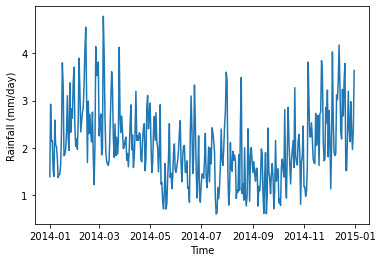

In [9]:
%%time
new_dtype = {
    "rain (mm/day)": np.float32
}

df = pd.read_csv(
    "figshareclimate_data/combined_data.csv",
    parse_dates=["time"],
    dtype=new_dtype
).query("time >= '2014-01-01' and time <= '2014-12-31'")
df["time"] = df["time"].dt.date

agg_df = df.groupby(by="time").mean()
agg_df.plot.line(
    y="rain (mm/day)",
    legend=False,
    xlabel="Time",
    ylabel="Rainfall (mm/day)"
);

#### 3. Loading required columns only

CPU times: user 42.7 s, sys: 7.13 s, total: 49.9 s
Wall time: 54.5 s


<AxesSubplot:xlabel='Time', ylabel='Rainfall (mm/day)'>

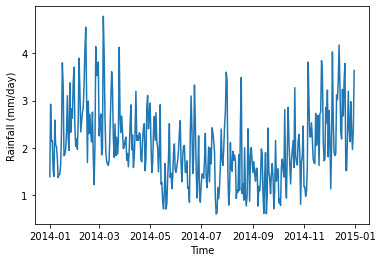

In [10]:
%%time
use_cols = ["time", "rain (mm/day)"]

df = pd.read_csv(
    "figshareclimate_data/combined_data.csv",
    parse_dates=["time"],
    usecols=use_cols
).query("time >= '2014-01-01' and time <= '2014-12-31'")
df["time"] = df["time"].dt.date

agg_df = df.groupby(by="time").mean()
agg_df.plot.line(
    y="rain (mm/day)",
    legend=False,
    xlabel="Time",
    ylabel="Rainfall (mm/day)"
);

#### 4. Changing `dtype` and loading required columns

CPU times: user 42.7 s, sys: 6.72 s, total: 49.4 s
Wall time: 53.6 s


<AxesSubplot:xlabel='Time', ylabel='Rainfall (mm/day)'>

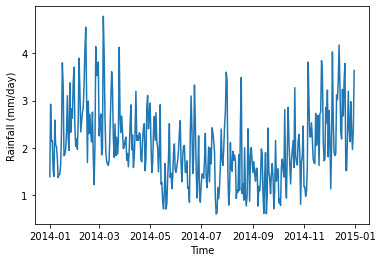

In [11]:
%%time
use_cols = ["time", "rain (mm/day)"]
new_dtype = {
    "rain (mm/day)": np.float32
}

df = pd.read_csv(
    "figshareclimate_data/combined_data.csv",
    parse_dates=["time"],
    usecols=use_cols,
    dtype=new_dtype
).query("time >= '2014-01-01' and time <= '2014-12-31'")
df["time"] = df["time"].dt.date

agg_df = df.groupby(by="time").mean()
agg_df.plot.line(
    y="rain (mm/day)",
    legend=False,
    xlabel="Time",
    ylabel="Rainfall (mm/day)"
);

<br>

## Transferring dataframe from Python to R

**Approach:** The approach chosen is to use a feather file which stores the data to the disk.

Using a feather file was chosen because feather is typically used for short term storage in situations like dataframe transfers. This dataframe will likely only be used for the DSCI 525 course which is very short term and hence, a feather file is appropriate.

A parquet file was not chosen because we do not require long term storage. Although parquet files have predicate pushdown and projection pushdown capabilities, there are only a few columns in the dataframe. In this specific EDA question, predicate pushdown could be useful to filter dates in 2014 only.

Pandas exchange was not chosen because as seen in the lecture, the serialization/deserialization process takes a longer time than Arrow exchange.

Arrow exchange was the other alternative considered for this dataframe transfer because arrow in-memory files have a unified format across all platforms which make it very versatile. Furthermore, it is faster than Pandas exchange, a zero-copy process, and arrow is also well integrated with R's dplyr package. However, in this milestone, we are only working with Python and R so we will not be exploiting much of arrow's cross-platform advantages. Additionally, having a feather file stored in the disk as opposed to in-memory only can also be advantageous if we would like to work solely in R.

In [12]:
df = pd.read_csv(
    "figshareclimate_data/combined_data.csv",
    parse_dates=["time"])
df["time"] = df["time"].dt.date

feather.write_feather(
    df,
    "figshareclimate_data/combined_data.feather"
)

<br>

## EDA in R

**Question:** What is the mean aggregated rainfall predicted by all the models for 2014?

In [13]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(arrow))

df <- arrow::read_feather("figshareclimate_data/combined_data.feather")
head(df)

# A tibble: 6 × 7
  time       lat_min lat_max lon_min lon_max `rain (mm/day)` model          
  <date>       <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>          
1 1889-01-01   -35.4   -33.6    142.    143.        4.24e-13 MPI-ESM-1-2-HAM
2 1889-01-02   -35.4   -33.6    142.    143.        4.22e-13 MPI-ESM-1-2-HAM
3 1889-01-03   -35.4   -33.6    142.    143.        4.50e-13 MPI-ESM-1-2-HAM
4 1889-01-04   -35.4   -33.6    142.    143.        4.25e-13 MPI-ESM-1-2-HAM
5 1889-01-05   -35.4   -33.6    142.    143.        4.27e-13 MPI-ESM-1-2-HAM
6 1889-01-06   -35.4   -33.6    142.    143.        4.20e-13 MPI-ESM-1-2-HAM


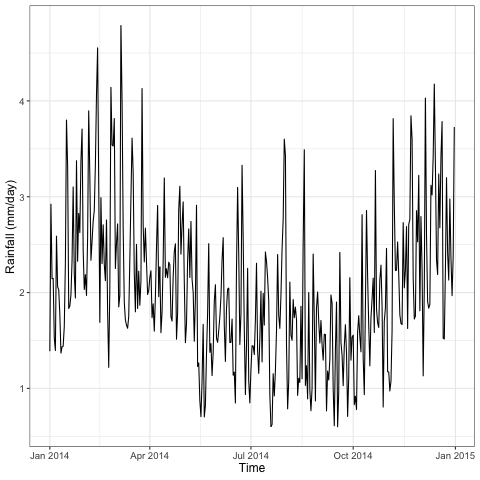

In [14]:
%%R

df %>%
    filter(time >= "2014-01-01", time <= "2014-12-31") %>%
    group_by(time) %>%
    summarise(rainfall = mean(`rain (mm/day)`, na.rm = TRUE)) %>%
    ggplot(aes(x = time, y = rainfall)) +
    geom_line() +
    labs(x = "Time", y = "Rainfall (mm/day)") +
    theme_bw() +
    theme(text = element_text(size = 12))

<br>

# Milestone 1 discussion

**1. Discuss any challenges or difficulties you faced when dealing with this large amount of data on your laptops. Briefly explain your approach to overcome the challenges or reasons why you could not overcome them.**

The biggest challenge was the high time-consuming process to run the entire code. This database is quite huge and our personal computers took a long time to process the code chunks. We couldn't avoid this type of problem since we weren't using online tools for big data and we couldn't improve our computers due to the high cost of powerful machines to run this size of data. We need to wait for each code chunk to run, and some of them took more than 15 minutes to run. It goes to show that it is quite complex to deal with big data on the personal computer since any changes in the process or any updates would cost a lot of time to be accomplished.


**2. Comparisons for the time taken to combine data CSVs and loading the combined CSV to memory to perform EDA**

| Team Member | Operating System              | RAM   | Processor      | Is SSD | Time taken - Combining data CSVs (CPU time / Wall time) | Time taken - EDA (CPU time / Wall time) |
|-------------|-------------------------------|-------|----------------|--------|:--------------------------------------------------------:|:-----------------------------------------:| 
| Josh        | macOS Big Sur Version 11.5.2  | 8GB   | Apple M1       | TRUE   | 6min 59s / 7min 12s                                     | 3min 43s / 3min 49s                     | 
| Aldo        | Windows 10 version 10.0       | 16GB  | intel core i-7 | TRUE   | 8min 29s / 8min 31s                                     | 5min 2s / 5min 36s                     | 
| Arijeet      | macOS Big Sur Version 11.6    | 8GB   | Apple M1       | TRUE   | 9min 19s / 9min 26s                                     | 3min 37s /  3min 57s                     | 

From the table above we can conclude that the time taken to combine the csv files is high in comparison with EDA and also any other step that we observed during the entire process. There is a difference in CPU time and wall time. Wall time measures how much time has passed as if you were looking at the clock on your wall. CPU time is how many seconds the CPU was busy and for both measures, the time taken to combine data CSVs is large and any updates or changes in this step would be a time-consuming process. Generally speaking, we also observe that macOS with Apple M1 performed better than Windows with intel i-7 for both combining CSVs and EDA.

You can check further information about the code in the `notebooks/milestone1.ipynb` file within this repository.
